In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference

import autograd.numpy as np
from neuralsolver import NNSolver

import seaborn as sns
sns.set()

In [8]:
"""
Reference:
Lagaris, Isaac E., Aristidis Likas, and Dimitrios I. Fotiadis.
"Artificial neural networks for solving ordinary and partial
differential equations." IEEE Transactions on Neural Networks
 9.5 (1998): 987-1000.
"""

# autograd core
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad as egrad

# autograd utils
import autograd.numpy.random as npr
from autograd.misc.flatten import flatten

# scipy optimizer
from scipy.optimize import minimize

#plot animation
from matplotlib import animation, rc
from IPython.display import HTML

# A global counter for printing scipy training progress
# https://stackoverflow.com/questions/16739065/how-to-display-progress-of-scipy-optimize-function
# TODO: Can we improve this dirty hack?
count = 0


def init_weights(n_in=1, n_hidden=10, n_out=1):
    '''
    Initialize NN weights
    '''
    # TODO: more layers?
    W1 = npr.randn(n_in, n_hidden)
    b1 = np.zeros(n_hidden)
    W2 = npr.randn(n_hidden, n_out)
    b2 = np.zeros(n_out)
    params = [W1, b1, W2, b2]
    return params


def predict(params, t, y0, act=np.tanh):
    '''
    Make NN prediction
    '''
    W1, b1, W2, b2 = params

    a = act(np.dot(t, W1) + b1)
    out = np.dot(a, W2) + b2  # standard NN output

    # TODO: start with t0 instead of 0
    y = y0 + t*out  # apply Lagaris et al. (1998)

    return y
   


predict_dt = egrad(predict, argnum=1)  # element-wise grad w.r.t t


class NNSolver(object):
    def __init__(self, f, t, y0_list, n_hidden=10):
        '''
        Neural Network Solver Class
        Parameters
        ----------
        f : callable
            Right-hand side of the ODE system dy/dt = f(t, y).
            Similar to the input for scipy.integrate.solve_ivp()
            Important notes:
            - Must use autograd's numpy inside f (import autograd.numpy as np)
            - For a single ODE, should return a list of one element.
        t : column vector, i.e. numpy array of shape (n, 1)
            Training points
        y0_list : a list of floating point numbers
            Initial condition.
            For a single ODE, should be a list of one element.
        n_hidden : integer, optional
            Number of hidden units of the NN
        '''

        Nvar = len(y0_list)
        assert len(f(t[0], y0_list)) == Nvar, \
            'f and y0_list should have same size'

        assert t.shape == (t.size, 1), 't must be a column vector'

        self.Nvar = Nvar
        self.f = f
        self.t = t
        self.y0_list = y0_list
        self.n_hidden = n_hidden

        self.reset_weights()

    def __str__(self):
        return ('Neural ODE Solver \n'
                'Number of equations:       {} \n'
                'Initial condition y0:      {} \n'
                'Numnber of hidden units:   {} \n'
                'Number of training points: {} '
                .format(self.Nvar, self.y0_list, self.n_hidden, self.t.size)
                )

    def __repr__(self):
        return self.__str__()

    def reset_weights(self):
        '''reinitialize NN weights (randomly)'''
        self.params_list = [init_weights(n_hidden=self.n_hidden)
                            for _ in range(self.Nvar)]

        flattened_params, unflat_func = flatten(self.params_list)
        self.flattened_params = flattened_params
        self.unflat_func = unflat_func

    def loss_func(self, params_list):
        '''Compute loss function'''
        # params_list should be an explicit input, not from self

        # some shortcut
        y0_list = self.y0_list
        t = self.t
        f = self.f

        y_pred_list = []
        dydt_pred_list = []
        for params, y0 in zip(params_list, y0_list):
            y_pred = predict(params, t, y0)
            dydt_pred = predict_dt(params, t, y0)

            y_pred_list.append(y_pred)
            dydt_pred_list.append(dydt_pred)

        f_pred_list = f(t, y_pred_list)

        loss_total = 0.0
        for f_pred, dydt_pred in zip(f_pred_list, dydt_pred_list):
            loss = np.mean((dydt_pred-f_pred)**2)
            loss_total += loss

        return loss_total

    def loss_wrap(self, flattened_params):
        '''Loss function that takes flattened parameters, for scipy optimizer
        '''
        # flattened_params should be an explicit input, not from self
        params_list = self.unflat_func(flattened_params)

        return self.loss_func(params_list)

    def train(self, method='BFGS', maxiter=2000, iprint=200):
        '''
        Train the neural net

        Parameters
        ----------
        method : string, optional
            Optimization method for scipy.optimize.minimize()
            'BFGS' should be the most robust one

        maxiter : integer, optional
            Maximum number of iterations

        maxiter : integer, optional
            Print loss per iprint step
        '''
        self.x = [] # updates of x during training



        global count
        global loss_arr
        count = 0  # reset counter for next training
        loss_arr = []
        def print_loss(x):
            global count
            if count % iprint == 0:
                print("iteration:", count, "loss: ", self.loss_wrap(x))
            count += 1

            # add new training updates to x
            self.x.append(self.unflat_func(x))
            loss_arr.append(self.loss_wrap(x))

        opt = minimize(self.loss_wrap, x0=self.flattened_params,
                       jac=grad(self.loss_wrap), method=method,
                       callback=print_loss,
                       options={'disp': True, 'maxiter': maxiter})

        # update parameters
        self.flattened_params = opt.x
        self.params_list = self.unflat_func(opt.x)
        

    def predict(self, t=None, params_list=None):
        '''
        Make new predicts

        Parameters
        ----------
        t : column vector, i.e. numpy array of shape (n, 1), optional
            use training points by default

        '''
        if t is None:
            t = self.t

        if params_list is None:
            y_pred_list = []
            dydt_pred_list = []
            for params, y0 in zip(self.params_list, self.y0_list):
                y_pred = predict(params, t, y0)
                dydt_pred = predict_dt(params, t, y0)

                y_pred_list.append(y_pred.squeeze())
                dydt_pred_list.append(dydt_pred.squeeze())

            return y_pred_list, dydt_pred_list
        
        else:
            y_pred_list = []
            for params, y0 in zip(params_list, self.y0_list):
                y_pred = predict(params, t, y0)

                y_pred_list.append(y_pred.squeeze())

            return y_pred_list
    def result(self,t = None, anim = False, interval = 50, every_n_iter = 1):
        '''
        Note: need to brew install ffmpeg
        t: array like, evaluate at these points
        anim: whether to plot animation or not
        interval: time duration between frames, in ms
        every_n_iter: plot every n iterations of the trainning process, if num of iteration if large, 
        increase every_n_iter to save computi
        '''
        if t is None:
            t = self.t
            
        
        if anim:
            
            #training animation 
            y_train = np.array([self.predict(t = t.reshape(-1,1), params_list=x) for x in self.x])[::-every_n_iter][::-1]
            n = y_train.shape[1]
            
            
            fig, ax = plt.subplots(1,2,figsize = (16,6))
            
            
            #ground truth using scipy
            sol_cont = solve_ivp(self.f, [t.min(), t.max()], self.y0_list, method='Radau', rtol=1e-5)
            sol_dis = solve_ivp(self.f, t_span = [t.min(), t.max()], t_eval=t, y0 = self.y0_list, method='Radau', rtol=1e-5)
            y_diff = np.array([np.array(sol_dis.y[i]) for i in range(n)])
            
            
            #set x y limit using min and max of the last iteration
            ax[0].set_xlim((t[0], t[-1]))
            ax[0].set_ylim((np.min(y_train[-1,:,:]), np.max(y_train[-1,:,:])))
            
            ax[1].set_xlim((t[0], t[-1]))
            ax[1].set_ylim((np.min(y_train[-1,:,:] - y_diff), np.max(y_train[-1,:,:] - y_diff)))
            
            #plot ground truth
            for i in range(n):
                ax[0].plot(sol_cont.t, sol_cont.y[i], label='y{}'.format(i+1))
                        
            #plots of NN result
            scatters_pred = []
            scatters_diff = []
            for i in range(n):
        
                scat1 = ax[0].scatter([], [], label = 'y_pred{}'.format(i+1))
                scatters_pred.append(scat1)
                
                scat2 = ax[1].scatter([], [], label = 'y{}'.format(i+1))
                scatters_diff.append(scat2)
            
            ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, ncol=4)
            ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, ncol=4)
            
            ax[0].set_title("NN Prediction and Truth", fontsize = 18)
            ax[1].set_title("NN Prediction - Truth", fontsize = 18)
            # initialization function: plot the background of each frame
            def init():
                for k in range(n):
                    scatters_pred[k].set_offsets(np.hstack(([], [])))
                    scatters_diff[k].set_offsets(np.hstack(([], [])))
                return (scatters_pred + scatters_diff)
            
            # animation function. This is called sequentially
            
            def animate(i):
                for k in range(n):
                    scatters_pred[k].set_offsets(np.c_[t, y_train[i,k,:]])
                    
                    scatters_diff[k].set_offsets(np.c_[t, y_train[i,k,:] - y_diff[k]])
                    
                return (scatters_pred + scatters_diff)
            
            # call the animator. blit=True means only re-draw the parts that have changed.
            anim_pred = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=y_train.shape[0], interval=interval, blit=True)
            
#             anim_diff = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=y_train.shape[0], interval=interval, blit=True)
            
            
            
            
            return anim_pred#, anim_diff
    def plot_loss(self):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(loss_arr)), loss_arr)
        plt.title("Loss", fontsize = 18)
        plt.show()

**Due to internal code design, single ODE should also be written in a ODE system form.**

In [9]:
def f(t, y):
    '''
        dy/dt = f(t, y)
        This is f() function on the right
    '''    
    
    return [t*(998*y[0] + 1998*y[1]), -999*y[0] - 1999*y[1]]

t = np.linspace(0, 2.0, 11).reshape(-1,1) # training points
y0_list = [2, -1]

In [10]:
sol = solve_ivp(f, [t.min(), t.max()], y0_list, method='Radau', rtol=1e-5)

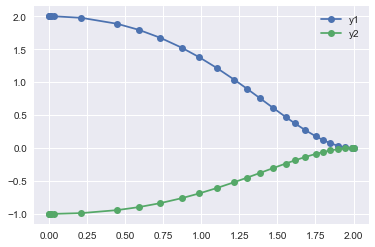

In [11]:
plt.plot(sol.t, sol.y[0], marker='o', label='y1')
plt.plot(sol.t, sol.y[1], marker='o', label='y2')
plt.legend()

In [12]:
nn = NNSolver(f, t, y0_list)
nn

Neural ODE Solver 
Number of equations:       2 
Initial condition y0:      [2, -1] 
Numnber of hidden units:   10 
Number of training points: 11 

In [13]:
nn.reset_weights()
%time nn.train()

iteration: 0 loss:  239295.22375
iteration: 200 loss:  0.0766081459042
iteration: 400 loss:  0.074829911229
iteration: 600 loss:  0.0738023159084
iteration: 800 loss:  0.0732689942716
iteration: 1000 loss:  0.0731899546584
iteration: 1200 loss:  0.0727031103002
iteration: 1400 loss:  0.0723947378913
iteration: 1600 loss:  0.07179644359
iteration: 1800 loss:  0.0712875368383
         Current function value: 0.070488
         Iterations: 2000
         Function evaluations: 2308
         Gradient evaluations: 2308
CPU times: user 19.7 s, sys: 145 ms, total: 19.8 s
Wall time: 19.9 s


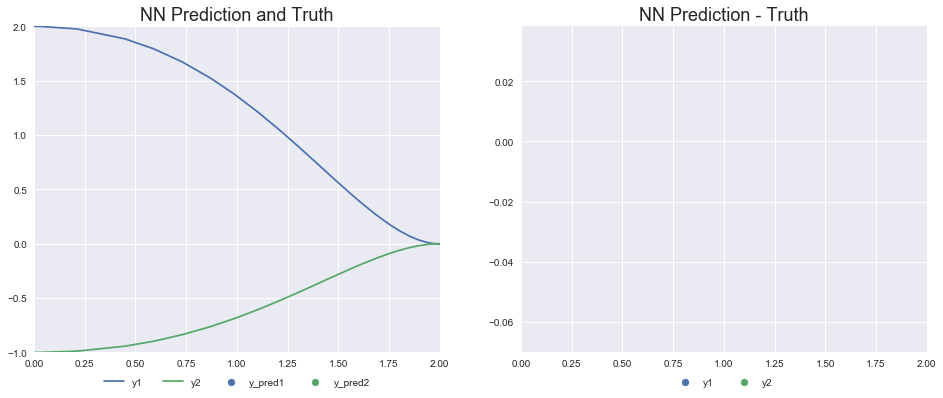

In [14]:
anim = nn.result(t = np.linspace(0, 2.0, 20), interval=20, anim=True, every_n_iter=50)

In [15]:
HTML(anim.to_html5_video())

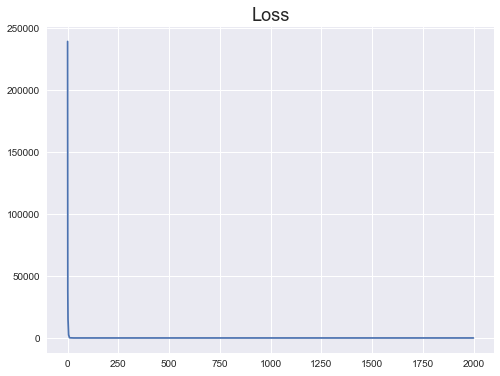

In [16]:
nn.plot_loss()

---